<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com) for PyCon 2015. Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_pycon2015/).</i></small>

# 介绍Scikit-Learn：用Python进行机器学习

这部分将覆盖基本Scikit-Learn（下面简称sklearn），它是一种Python实现的机器学习工具集。详见：http://scikit-learn.org

## 概要

**主要目标**：介绍机器学习核心概念，和如何使用sklearn包。
- 机器学习的定义
- sklearn中的数据表示
- sklearn API介绍

## 关于Scikit-Learn

[sklearn](http://scikit-learn.org)用Python实现了许多众所周知的机器学习算法，并且提供清晰和成熟的API接口。全世界达数百人参与贡献了sklearn的代码，它在工业和学术界被大量应用。
sklearn基于[NumPy](www.numpy.org)和[SciPy](http://scipy.org)，这两个库在数组处理和科学计算方面很强大。此外sklearn不适合大数据集处理，尽管在这方面已经做了一些[工作](https://github.com/ogrisel/parallel_ml_tutorial)。

# 什么是机器学习？

在这部分我们将开始探索基本的机器学习规则。机器学习通过调整参数来学习已知的数据，从而建立模型来预测新的数据。机器学习作为人工智能的一个领域，通过某种程度的泛化使得计算机更加智能。

这里我们将看一下两个非常简单的例子。第一个是**分类**,图片显示一个二维数据的集合，不同的颜色表示不同的分类。一个分类算法可以划分两种不同颜色的点集：


In [1]:
%matplotlib inline

# set seaborn plot defaults.
# This can be safely commented out
import seaborn; seaborn.set()

# eliminate warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

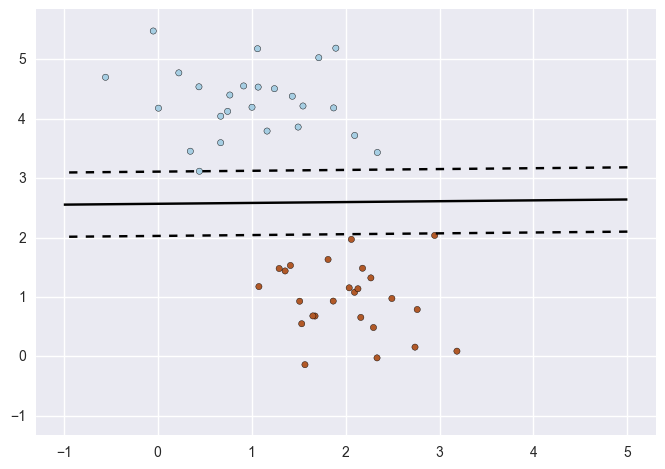

In [4]:
# Import the example plot from the figures directory
from fig_code import plot_sgd_separator
plot_sgd_separator()

这貌似像一个简单的任务，但大道至简。通过画出分割线形成模型，我们可以让这个模型泛化到新的数据集，它可以用来预测分割新的点集（红色和蓝色）。

如果你想要查看源码，可以使用`%load`命令。

In [ ]:
# %load fig_code/sgd_separator.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.datasets.samples_generator import make_blobs

def plot_sgd_separator():
    # we create 50 separable points
    X, Y = make_blobs(n_samples=50, centers=2,
                      random_state=0, cluster_std=0.60)

    # fit the model
    clf = SGDClassifier(loss="hinge", alpha=0.01,
                        n_iter=200, fit_intercept=True)
    clf.fit(X, Y)

    # plot the line, the points, and the nearest vectors to the plane
    xx = np.linspace(-1, 5, 10)
    yy = np.linspace(-1, 5, 10)

    X1, X2 = np.meshgrid(xx, yy)
    Z = np.empty(X1.shape)
    for (i, j), val in np.ndenumerate(X1):
        x1 = val
        x2 = X2[i, j]
        p = clf.decision_function(np.array([[x1, x2]]))
        Z[i, j] = p[0]
    levels = [-1.0, 0.0, 1.0]
    linestyles = ['dashed', 'solid', 'dashed']
    colors = 'k'

    ax = plt.axes()
    ax.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

    ax.axis('tight')


if __name__ == '__main__':
    plot_sgd_separator()
    plt.show()


下一个我们看下**回归**的例子，数据集的最佳拟合线

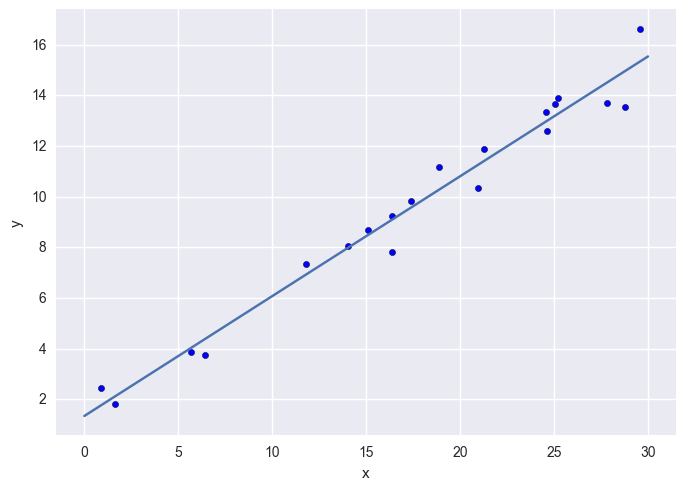

In [7]:
from fig_code import plot_linear_regression
plot_linear_regression()

我们又看到了一个拟合数据的模型，这个模型也可以泛化到新的数据。这个模型通过学习训练数据，从而预测测试集的结果：给它x值，它可以预测y值。

## 数据在Scikit-learn中的表示

机器学习通过数据建立模型，基于这点，我们开始讨论，数据如何表示才能让计算机可以理解。我们将举一些matplotlib的例子并且可视化它们。

在sklearn中的大多数机器学习算法的数据存储在二维的数组或者矩阵中。有的采用``numpy arrays``，还有的采用``scipy.sparse``矩阵。数组的大小设定为`[n_samples, n_features]`

- **n_samples:** 样本的个数，每个样本是待处理的一项数据。它可以是一篇文档，一张图片，一段音频，一段视频，数据库或CSV文件中的某一行，甚至一个你能描述其特征的可量化的集合。
- **n_features** 特征的数目，用一种可以量化的方式来描述每一个样本的特征数目。它一般是实数，在一些场合下可以为布尔值或者离散的数值。

特征的数量必须是提前确定的。它可能有很高的维度（例如：上百万的维度），其中一些样本中大部分的特征值为零。在这种场景下scipy.sparse矩阵就很有用了，它比numpy arrays更加节约内存。


## 一个简单的例子：Iris（鸢尾花）数据集

在这个例子中，我们将看一下存储在sklearn中的iris数据。这个数据集包含三种不同种类的iris测量值。让我们看下下图：

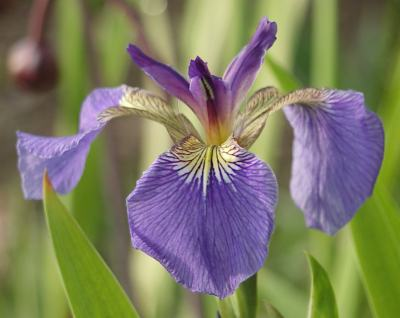

Iris Setosa



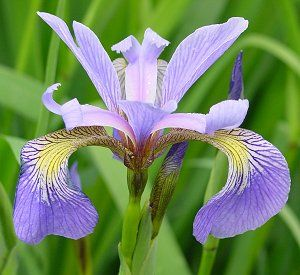

Iris Versicolor



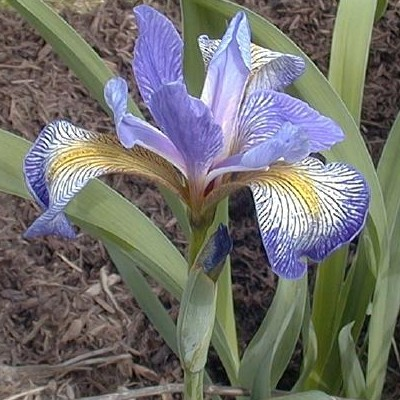

Iris Virginica


In [8]:
from IPython.core.display import Image, display
display(Image(filename='images/iris_setosa.jpg'))
print("Iris Setosa\n")

display(Image(filename='images/iris_versicolor.jpg'))
print("Iris Versicolor\n")

display(Image(filename='images/iris_virginica.jpg'))
print("Iris Virginica")

### 问题：
**如果我们需要一个算法来识别不同种类的iris（鸢尾花），需要哪些数据？**

我们需要一个`[n_samples x n_features]`的二维数组

- `n_samples`表示什么？
- `n_features`表示什么？

每一个样本必须有确定数量的特征，每个特征都是样本的某种量化值。


### 从sklearn中加载iris数据集

    
sklearn中包含了这些种类的iris数据集。这数据集包含下面的特征值：

- 数据集中的特征：
1. 花萼长度（单位cm）
2. 花萼宽度（单位cm）
3. 花瓣长度（单位cm）
4. 花瓣宽度（单位cm）

- 预测的目标分类：
1. 山鸢尾（Iris Setosa）
2. 杂色鸢尾（Iris Versicolour）
3. 维吉尼亚鸢尾（Iris Virginica）

``sklearn``包含iris的CSV文件包括加载到numpy arrays的函数：

In [10]:
from sklearn.datasets import load_iris
iris = load_iris()

In [11]:
iris.keys()

['target_names', 'data', 'target', 'DESCR', 'feature_names']

In [12]:
n_samples, n_features = iris.data.shape
print((n_samples, n_features))
print(iris.data[0])

(150, 4)
[ 5.1  3.5  1.4  0.2]


In [13]:
print(iris.data.shape)
print(iris.target.shape)

(150, 4)
(150,)


In [14]:
print(iris.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


这个数据集是四维的，但是我们可以用scatter plot每次展示两维：

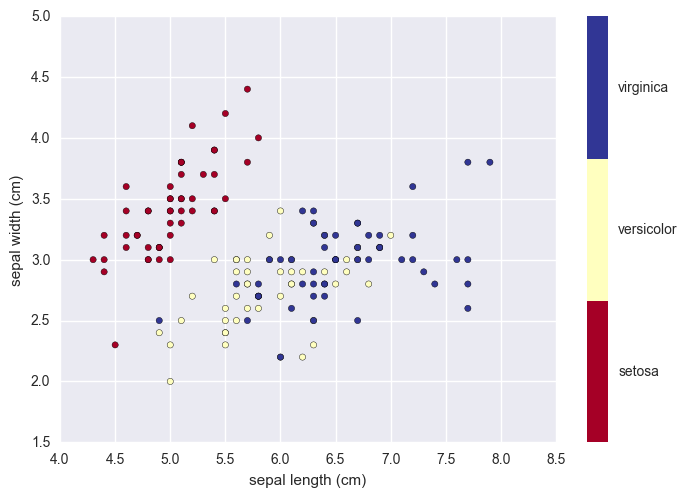

In [15]:
import numpy as np
import matplotlib.pyplot as plt

x_index = 0
y_index = 1

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])

plt.scatter(iris.data[:, x_index], iris.data[:, y_index],
            c=iris.target, cmap=plt.cm.get_cmap('RdYlBu', 3))
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.clim(-0.5, 2.5)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index]);

### 练习

改变上面代码中`x_index`和`y_index`值，找出一个点可以最大化的分割这三类

这是个**降维**的练习，我们稍后会见到。

## 其他可用的数据

有以下的三种形式：

- **sklearn包数据** 在安装的时候，这些小的数据集被打包在sklearn中，通过``sklearn.datasets.load_*``函数能够被加载
- **下载的数据** 这些大的数据集可以通过sklearn提供的``sklearn.datasets.fetch_*``函数从网上下载
- **生成的数据** 这些数据可以通过sklearn提供的``sklearn.datasets.make_*``函数，基于一个随机种子从模型中产生

你能通过IPython的tab补全功能，浏览这些函数。在从sklearn中导入``datasets``子模块后，你可以
输入datasets.load_ + TAB或datasets.fetch_ + TAB或datasets.make_ + TAB来浏览这些函数列表。

In [16]:
from sklearn import datasets

In [17]:
# Type datasets.fetch_<TAB> or datasets.load_<TAB> in IPython to see all possibilities

# datasets.fetch_

In [18]:
# datasets.load_

在下一章，我们将使用这些数据集，并且学习机器学习的基本方法。